In [5]:
import matplotlib.pyplot as plt
import numpy
import daft
import seaborn

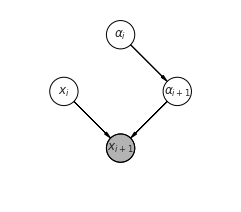

In [8]:
pgm = daft.PGM([4, 3.5])
pgm.add_node(daft.Node('x_0', r"$x_i$", 1, 2))
pgm.add_node(daft.Node('x_1', r"$x_{i+1}$", 2, 1, observed=True))
pgm.add_node(daft.Node('alpha_0', r"$\alpha_i$", 2, 3))
pgm.add_node(daft.Node('alpha_1', r"$\alpha_{i+1}$", 3, 2))

pgm.add_edge('x_0', 'x_1')
pgm.add_edge('alpha_1', 'x_1')
pgm.add_edge('alpha_0', 'alpha_1')

pgm.render()
plt.show()

In [3]:
import pystan

In [120]:
model = """
data {
  int<lower=0> N; // number of time steps
  vector[N] x; // all x[i] measurements
  real prior_a;
  real prior_a_s;
}
parameters {
  real<lower=0> alpha[N];
  real<lower=0> sigma;
  real<lower=0> alpha_variance_per_step;
}
model {
  alpha[1] ~ normal(prior_a, prior_a_s);
  // alpha_variance_per_step ~ normal()
  for (n in 2:N) {
    alpha[n] ~ normal(alpha[n-1], alpha_variance_per_step);
    x[n] ~ normal( (1+alpha[n]) * x[n-1], sigma);
  }
}
"""

In [121]:
stan = pystan.StanModel(model_code=model)

INFO:pystan:COMPILING THE C++ CODE FOR MODEL anon_model_74aa15bdd2ee6a1d59029ee002693ad9 NOW.


In [6]:
xs = [ 1, 1.21, 1.37, 1.758, 2.0636, 2.23, 2.4, 2.6, 2.65, 2.72 ]
N = len(xs)
data = {
    'N': N,
    'x': xs,
    'prior_a': 0.3, # (x data was generated from an alpha changing from 0.2 to 0.02)
    'prior_a_s': 1,
#     'alpha_variance_per_step': 0.03,
}

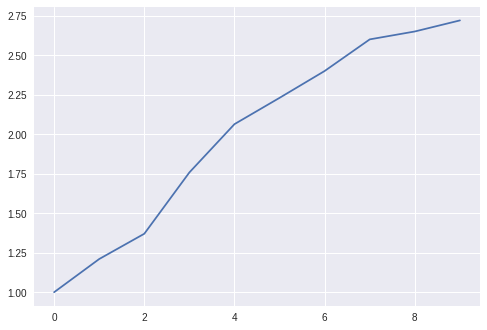

In [7]:
plt.plot(xs)
plt.show()

In [124]:
fit = stan.sampling(data=data, iter=10000)
print(fit)

Inference for Stan model: anon_model_74aa15bdd2ee6a1d59029ee002693ad9.
4 chains, each with iter=10000; warmup=5000; thin=1; 
post-warmup draws per chain=5000, total post-warmup draws=20000.

                          mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
alpha[0]                  0.19  1.2e-3   0.08   0.04   0.13   0.18   0.23   0.37   4681    1.0
alpha[1]                  0.18  1.3e-3   0.06   0.07   0.15   0.19   0.22   0.29   1834    1.0
alpha[2]                  0.16  9.5e-4   0.05   0.07   0.13   0.16   0.19   0.26   2570    1.0
alpha[3]                   0.2  1.9e-3   0.06   0.08   0.16   0.21   0.25    0.3   1049    1.0
alpha[4]                  0.16  9.7e-4   0.04   0.07   0.13   0.16   0.18   0.23   1623    1.0
alpha[5]                   0.1  4.9e-4   0.03   0.04   0.08    0.1   0.12   0.17   4058    1.0
alpha[6]                  0.08  5.1e-4   0.03   0.03   0.07   0.08    0.1   0.15   3199    1.0
alpha[7]                  0.08  5.1e-4   0.03   0

## Check

Now to see whether everything makes sense, we create an imaginary data set using the posterior means for the model parameters, and then plot that imaginary data against the original data that was used to fit the model and produce those posterior means.

In [125]:
posterior_mean_alpha = [ numpy.mean(fit.get_posterior_mean()[i]) for i in range(N) ]
posterior_mean_alpha

[0.1854926461741698,
 0.18284251117074166,
 0.16356530165981165,
 0.20344568503826033,
 0.1557341326717234,
 0.098617371669135243,
 0.083225532590413348,
 0.077468204823522707,
 0.041528327731763286,
 0.041178553143456552]

In [126]:
check_data_from_posterior_means = []
x = 1
for i in range(N):
    check_data_from_posterior_means.append(x)
    x = x * (1 + posterior_mean_alpha[i])
# check_data_from_posterior_means

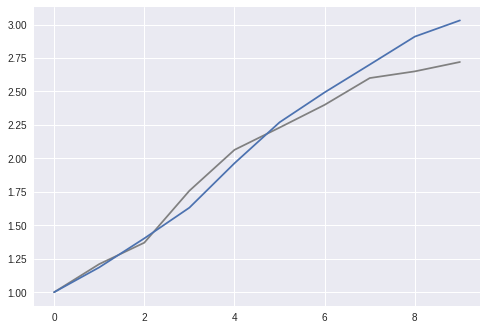

In [127]:
plt.plot(xs, color="gray") # Original data
plt.plot(check_data_from_posterior_means) # Data generated from posterior means of the fitted model
plt.show()